In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pandas as pd
import numpy as np
import json

In [3]:
metadata_file = '../../data/ambient_network.json'

with open(metadata_file) as f:
    ambient_network = json.load(f)
    
#ambient_network

In [4]:
wrtdsk_load = pd.read_csv('../../data/Illinois_annual_wrtds-k_loads.csv', dtype={'site_no':str})

wrtdsk_load['year'] = pd.to_datetime(wrtdsk_load['year'], format='%Y').values
wrtdsk_load = wrtdsk_load.set_index(['site_no','year'])

wrtdsk_load.head()
#wrtdsk_load.index.dtypes

00530_kg  00535_kg    00600_kg  00610_kg    00625_kg  \
site_no  year                                                                   
03336645 1979-01-01  4.245040e+08       NaN  5211629.08       NaN  2073863.64   
         1980-01-01  2.530749e+08       NaN  2918988.52       NaN  1026367.54   
         1981-01-01  2.041528e+08       NaN  4654886.00       NaN   945191.74   
         1982-01-01  5.166362e+08       NaN  6150387.24       NaN  2975568.52   
         1983-01-01  9.635003e+07       NaN  3891292.98       NaN   723070.12   

                       00630_kg   00665_kg  00666_kg  00667_kg     00946_kg  \
site_no  year                                                                 
03336645 1979-01-01  3759277.98  205410.92       NaN       NaN  23269956.76   
         1980-01-01  2070057.70   92282.17       NaN       NaN  13971288.33   
         1981-01-01  3442636.84        NaN  35899.39       NaN  18745524.02   
         1982-01-01  4238406.61        NaN  89622.15       NaN  27195534.22   
         1983-01-01  3133585.88        NaN  32643.86       NaN  20467948.32   

                     ...  00610_n  00625_n  00630_n  00665_n  00666_n  \
site_no  year        ...                                                
03336645 1979-01-01  ...        0       12       12       12        0   
         1980-01-01  ...        0       13       13        5        0   
         1981-01-01  ...        0       12        9        0        9   
         1982-01-01  ...        0        8        8        0        8   
         1983-01-01  ...        0        8        8        0        8   

                     00667_n  00946_n  80154_n  99220_n  flow_days  
site_no  year                                                       
03336645 1979-01-01        0       12        0        0        365  
         1980-01-01        0       13        0       13        366  
         1981-01-01        0       12        0       12        365  
         1982-01-01        0        8        0        8        365  
         1983-01-01        0        8        0        8        365  

[5 rows x 37 columns]

In [6]:
import xarray as xr
import pint_xarray


load_cols = ['00630_kg','00665_kg']
name_dict = {'00630_kg':'nitrate', '00665_kg':'phosphorus'}
wrtdsk_ds = wrtdsk_load.to_xarray()
wrtdsk_ds = wrtdsk_ds[load_cols].rename(name_dict=name_dict)


wrtdsk_ds = wrtdsk_ds.pint.quantify({'nitrate': 'kg', 'phosphorus': 'kg'})

d = wrtdsk_ds.pint.dequantify()
d.to_netcdf('../../data/ambient_wrtdsk_annual_loads.netcdf')
#wrtdsk_ds.pint.dequantify()
#wrtdsk_ds.pint.dequantify()


In [7]:
# format continuous data

In [8]:
#!gdown https://www.sciencebase.gov/catalog/file/get/61f97181d34e622189c510ad?f=__disk__09%2F1c%2Fd6%2F091cd6dd4d7272d2f484c8bd148e174adef2553e
import pandas as pd

cm_df = pd.read_csv('../../data/Illinois_nutrient_and_sediment_concentrations_wy2016-2021.csv', dtype={'USGS_site':str}, parse_dates=['datetime']).rename({'USGS_site':'site_no'}, axis=1)
cm_df = cm_df.set_index(['site_no','datetime'])

In [9]:
# convert concentrations to loads
CF_to_L = 28.3168
MG_to_KG = 1e-6
sec_to_day = 86400.0
conversion = CF_to_L * MG_to_KG * sec_to_day
cm_df['nitrate'] = cm_df['q'] * cm_df['no3_mg_per_l'] * conversion
cm_df['phosphorus'] = cm_df['q'] * cm_df['total_p_mg_per_l'] * conversion

In [10]:
import xarray as xr
import pint_xarray

load_cols = ['nitrate','phosphorus']
#name_dict = {'00630_kg':'nitrate', '00665_kg':'phosphorus'}
cm_ds = cm_df.to_xarray()
cm_ds = cm_ds[load_cols]
cm_ds['water_year'] = cm_ds.datetime.dt.year.where(cm_ds.datetime.dt.month < 10, cm_ds.datetime.dt.year + 1)

#cm_ds

In [11]:
#def water_year(datetime):
#    return datetime.dt.month

In [97]:
#cm_annual = cm_ds.groupby('datetime.year').sum().pint.quantify({'nitrate': 'kg', 'phosphorus': 'kg'})
cm_annual = cm_ds.groupby('water_year').sum().pint.quantify({'nitrate': 'kg', 'phosphorus': 'kg'})
cm_annual['water_year'] = pd.to_datetime(cm_annual['water_year'], format='%Y').values
cm_annual = cm_annual.rename({'water_year':'year'})
#
d = cm_annual.pint.dequantify()
d.to_netcdf('../../data/supergage_annual_loads.netcdf')


# scratch

In [64]:
cm_ds.sel(site_no='03339000').mean()

<xarray.Dataset>
Dimensions:     ()
Coordinates:
    site_no     <U8 '03339000'
Data variables:
    nitrate     float64 [kg] 6.877e+06
    phosphorus  float64 [kg] 3.283e+05

In [67]:
test = xr.load_dataset('../../data/ambient_wrtdsk_annual_loads.netcdf')
test.sel(site_no='03339000').mean()

<xarray.Dataset>
Dimensions:     ()
Coordinates:
    site_no     <U8 '03339000'
Data variables:
    nitrate     float64 8.184e+06
    phosphorus  float64 3.958e+05

In [33]:
cm_df.index.levels[1].year

Int64Index([2015, 2015, 2015, 2015, 2015, 2015, 2015, 2015, 2015, 2015,
            ...
            2021, 2021, 2021, 2021, 2021, 2021, 2021, 2021, 2021, 2021],
           dtype='int64', name='datetime', length=2192)

In [337]:
#wrtdsk_ds['00630_kg']

In [338]:
#wrtdsk_ds['00630_kg']

In [339]:
site_load = compute_network_loads(wrtdsk_ds, ambient_network)

In [71]:
def location_label(site):
    return site['river'] + ' ' + site['location']

def compute_river_load(ds, site, nested=True):
    site_load = ds.sel(site_no=site['gage_id'])
    site_load = site_load.drop_vars('site_no')
    site_load = site_load * site['scale_factor']


    upstream_gage = site.get('upstream_gage')
    
    if upstream_gage and nested:
        upstream_load = ds.sel(site_no=upstream_gage).drop_vars('site_no')
        site_load = site_load - upstream_load
        
    site_load = site_load.assign_coords(coords={'river':location_label(site)})
    
    return site_load


def compute_network_loads(ds, network, nested=True):
    rivers = []
    
    for site in network:
        rivers.append(compute_river_load(ds, site, nested))
        
    return xr.concat(rivers, dim='river')
    #return rivers

def network_labels(network):
    labels = []
    for site in network:
        nested = site.get('nested')

        if nested is None or nested==False:
            #print(nested)
            labels.append(location_label(site))
            
    return labels
#def compute_network_total(ds, network):
#    pass

def kg_to_lbs(x):
    return x * 2.20462

def kg_to_kt(x):
    return x * 1.0e-6

In [341]:
rivers = compute_network_loads(wrtdsk_ds, ambient_network)

In [342]:
network_labels(ambient_network)

['Rock at Joslin',
 'Green at Geneseo',
 'Illinois at Valley City',
 'Kaskaskia at Venedy Station',
 'Big Muddy at Murphysboro',
 'Little Wabash at Carmi',
 'Embarras at Ste. Mairie',
 'Vermilion at Danville']

In [343]:


ds = rivers.sel(river = network_labels(ambient_network)).sel(year=slice(1980,2021)).apply(kg_to_kt) # .sum(dim='river')

In [344]:
baseline = ds.sel(year=slice(1980,1996))

last5 = ds.sel(year=slice(2016,2021))

In [345]:
baseline.mean(dim='year')

Magnitude,[7.919322822352942 3.8880654188235297 92.05675047684704 5.03759148 0.9710192511764707 2.599422248125 5.811036961764706 8.175657912035295]
Units,kilogram
Magnitude,[0.710416025882353 0.27016897588235295 6.0143111531999995 1.1765586776470587 0.41186058588235297 0.84804399875 0.5630159046153845 0.3922854750375]
Units,kilogram


In [346]:
last5.mean(dim='year')

Magnitude,[23.559418301999994 5.369021004 96.57024072863999 4.265504394 0.780341026 3.3847849080000003 6.914533816 7.1634624726]
Units,kilogram
Magnitude,[1.1423454739999999 0.268496808 8.099665405439998 1.880064356 0.536254704 1.663977616 0.705835438 0.40866072834]
Units,kilogram


In [70]:
rivers.sel(river='Rock at Joslin').plot.scatter(x='year',y='nitrate')

NameError: name 'rivers' is not defined

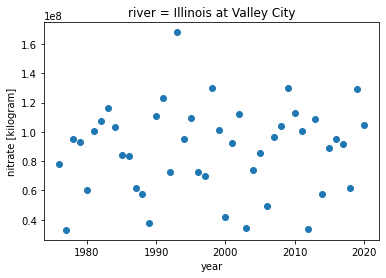

In [349]:
rivers.sel(river='Illinois at Valley City').plot.scatter(x='year',y='nitrate')

In [350]:


rivers.sel(year=slice(1980,2021)).sel(river='Rock at Rockton')#river

Magnitude,[9175423.29 13264272.47 16498291.53 20823128.78 14713805.88 22845541.63 24912909.14 22319648.21 14797664.74 7920105.95 11828435.71 15514921.27 22372817.27 35913517.86 19722480.37 17673158.3 23811169.93 20873126.43 20076361.81 22671368.06 18739996.53 19702561.9 19153628.83 10497757.95 16850689.55 12381654.47 13297022.87 19828287.47 26271542.79 20012056.52 20826067.35 17168731.76 10908144.1 18364927.36 13985937.18 12797513.51 20303477.29 26436287.13 21046431.51 31507286.53 27818528.17]
Units,kilogram
Magnitude,[1377918.89 1106281.55 2882574.79 1629631.03 1387967.33 1343751.81 1878301.05 1315880.54 855215.37 652848.97 938979.39 981370.53 1065776.7 2504113.84 1279173.35 857629.05 1649039.14 1414623.08 1135403.07 1205660.79 1001552.46 1088247.96 887267.09 451763.57 1157770.31 536296.28 530006.88 1033786.74 1807951.49 1138052.25 1278868.99 827911.69 400770.65 1115073.3 905432.26 594093.05 863539.35 1424587.17 1411463.04 1605350.2 1403538.3]
Units,kilogram
